In [447]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt
from matplotlib import rc

from garipov_deconvolution import get_coeff_simpson, Gold

In [448]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 14}
rc('font', **font_properties)

Создание энергетических спектров

In [449]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

# список энергий пучков электронов
beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)
beams_energyes = np.array(beams_energyes)

In [450]:
# зарядовые числа материалов мишеней
z_numbers = np.array([i for i in range(1, 101)])

In [451]:
def initialization_brem(material_z, beam_energy, tick=0.01):
    """
    Функция принимает материал мишени и энергию налетающего 
    электронного пучка
    Возвращаемое значение: генерируемый тормозной спектр
    """
    
    coefficient = Material(material_z).M()/material_z
    target = R(Material(material_z), tick*coefficient)
    bremsstrahlung = target.brem_mass(beam_energy)
    bremsstrahlung_en = bremsstrahlung * en
    
    return np.array(bremsstrahlung_en)

Построение энергетического спектра

In [534]:
z_example = 25 # номер материала мишени в списке материалов
en_example =  15 # порядковый номер в списке энергий
brem_example = initialization_brem(z_numbers[z_example], beams_energyes[en_example])

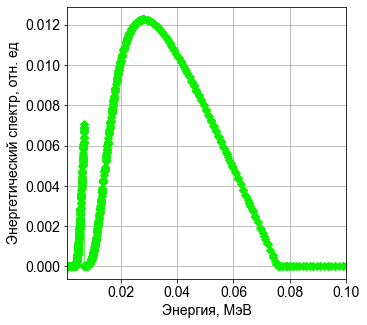

In [535]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(en, brem_example, ls='-', marker='D', lw='0.7', ms=5, color='#0FF000')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

# fig.savefig('Название_1.jpg', bbox_inches='tight')

Определение функций для создания матрицы спектров

In [454]:
def generate_empty_matrix(num_row, num_col):
    """
    Функция создает пустую матрицу заданных размеров
    Возвращает вложенный список
    """
    empty_matrix = [[[] for j in range(num_col)] for i in range(num_row)]
    return empty_matrix


def complete_empty_matrix(empty_matrix, array_1, array_2, func):
    """
    Функция заполняет пустую матрицу заданными элементами из массивов
    array_1, array_2 по правилу, определяемому функцией fucn.
    Возвращает заполненную матрицу np.ndarray
    """
    for row, val_1 in enumerate(array_1):
        for col, val_2 in enumerate(array_2):
            empty_matrix[row][col] = func(val_1, val_2)
            
    return np.array(empty_matrix)

Создание трехмерной матрицы спектров

In [455]:
# создание матрицы со всеми сгенерированными спектрами
empty_bremsstrahlungs_matrix = generate_empty_matrix(len(z_numbers), len(beams_energyes))
bremsstrahlungs = complete_empty_matrix(empty_bremsstrahlungs_matrix, z_numbers, beams_energyes, initialization_brem)

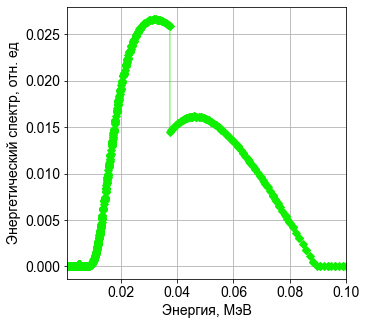

In [456]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(en, bremsstrahlungs[55][20], ls='-', marker='D', lw='0.7', ms=5, color='#0FF000')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

# fig.savefig('Название_2.jpg', bbox_inches='tight')

Создание списка К скачоков и добавление скачков, необходимых для учета при восстановлении

In [518]:
# материал первого фильтра 
n = 11

In [536]:
def get_edges():
    # Индексы К скачков
    EDGES = []
    for i in range(1, len(en)):
        if en[i - 1] == en[i]:
            EDGES.append(i - 1)
    return EDGES

def add_edges_to_mesh(material, EDGES):
    EDGES.remove(EDGES[EDGES.index(Material(material).k_index())])

In [537]:
EDGES = get_edges()
add_edges_to_mesh(z_example+1, EDGES)

Инициализация измерительных каналов

In [460]:
def rectangle_ideal(grid, material_num_1, material_num_2):
    """
    Функция создает один измерительный канал с полосой пропускания
    от энергии К1 до энергии К2
    """
    response = R(Material(1), 1).f()
    response[:] = 0
    response[Material(material_num_1).k_index() + 1:Material(material_num_2).k_index() + 1] = 1
    return response

bounds = [Material(i).k_index() for i in range(11, 101)]
bounds.append(0)

resp_rectangle = [rectangle_ideal(en, i, i+1) for i in range(11, 100)]
open_detector = np.array([1 for i in en])

Измерение одного спектра

In [461]:
K = np.array(resp_rectangle)
brem_e = brem_example

# произведение измерительного канала на спектр является результатом измерения
measurements = K*brem

In [462]:
def integrate_the_row(row):
    """
    Функция возвращает значение интеграла вычисленное
    по правилу Симпсона
    """
    return sum(get_coeff_simpson(row, en, EDGES)[0])


def get_row_integrate_coefficients(row):
    """
    Функция возвращает значения коэффициентов в узлах
    при вычислении интеграла по правилу Симпсона
    """
    return get_coeff_simpson(row, en, EDGES)[0]

In [538]:
# получение интегральный сигналов измерительных каналов
Integral_signals = np.apply_along_axis(integrate_the_row, arr=measurements, axis=1)
number_of_signals = len(Integral_signals)

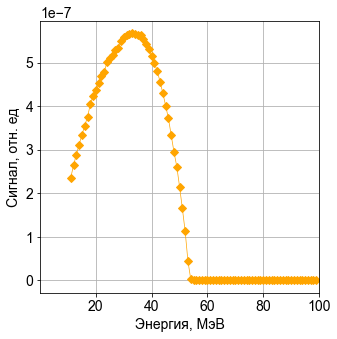

In [539]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(range(n, 100), Integral_signals, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Создание матрицы с результатами измерения каждого спектра

In [465]:
# матрица измерительных каналов
K = np.array(resp_rectangle)
# создание полного списка скачков
EDGES = get_edges()

def get_Integral_signals(bremsstrahlung, K):
    """
    Фукнция возвращает результаты измерения спектра
    измерительной системой R
    Параметры: 
    1) измеряемый спектр
    2) матрица измерительной системы
    """
    measurements = K*bremsstrahlung
    Integral_signals = np.apply_along_axis(integrate_the_row, arr=measurements, axis=1)
    return Integral_signals

def get_Integral_signals_open_decector(bremsstrahlung, K):
    """
    Фукнция возвращает результаты измерения спектра
    измерительной системой R
    Параметры: 
    1) измеряемый спектр
    2) матрица измерительной системы
    """
    measurements = K*bremsstrahlung
    Integral_signals = integrate_the_row(measurements)
    return Integral_signals

In [466]:
empty_integral_signals_matrix = generate_empty_matrix(len(z_numbers), len(beams_energyes))

In [467]:
def apply_function_to_matrix(objective_matrix, func, K):
    """
    Функция применяет правило, определяемое функцией func к
    каждому элементу целевой матрицы и создает матрицу возвращаемых
    значений
    Параметры:
    1) целевая матрица
    2) функция, определяющая возвращаемые значения
    """
    num_row = objective_matrix.shape[0]
    num_col = objective_matrix.shape[1]
    
    empty_matrix = generate_empty_matrix(num_row, num_col)
    
    # время начала
    start_time = time.time()
    
    for row in range(num_row):
        for col in range(num_col):
            empty_matrix[row][col] = func(objective_matrix[row][col], K)
            print(f'Выполнено {col+1} из {num_col}. Время: {round(time.time()-start_time, 4)} секунды')
        print(f'ВЫПОЛНЕНО {row+1} из {num_row} СТОЛБЦОВ. Время: {round(time.time()-start_time, 4)} секунды') 
    return np.array(empty_matrix)

In [468]:
SIGNALS = apply_function_to_matrix(bremsstrahlungs, get_Integral_signals, K)

Выполнено 1 из 50. Время: 2.0974 секунды
Выполнено 2 из 50. Время: 4.2547 секунды
Выполнено 3 из 50. Время: 6.3483 секунды
Выполнено 4 из 50. Время: 8.4283 секунды
Выполнено 5 из 50. Время: 10.5016 секунды
Выполнено 6 из 50. Время: 12.565 секунды
Выполнено 7 из 50. Время: 14.6364 секунды
Выполнено 8 из 50. Время: 16.718 секунды
Выполнено 9 из 50. Время: 18.7897 секунды
Выполнено 10 из 50. Время: 20.8533 секунды
Выполнено 11 из 50. Время: 22.9225 секунды
Выполнено 12 из 50. Время: 24.9912 секунды
Выполнено 13 из 50. Время: 27.0595 секунды
Выполнено 14 из 50. Время: 29.1604 секунды
Выполнено 15 из 50. Время: 31.2329 секунды
Выполнено 16 из 50. Время: 33.3052 секунды
Выполнено 17 из 50. Время: 35.376 секунды
Выполнено 18 из 50. Время: 37.4514 секунды
Выполнено 19 из 50. Время: 39.5329 секунды
Выполнено 20 из 50. Время: 41.6079 секунды
Выполнено 21 из 50. Время: 43.6611 секунды
Выполнено 22 из 50. Время: 45.7381 секунды
Выполнено 23 из 50. Время: 47.8142 секунды
Выполнено 24 из 50. Время: 

Выполнено 37 из 50. Время: 387.2974 секунды
Выполнено 38 из 50. Время: 389.3788 секунды
Выполнено 39 из 50. Время: 391.4374 секунды
Выполнено 40 из 50. Время: 393.5073 секунды
Выполнено 41 из 50. Время: 395.5745 секунды
Выполнено 42 из 50. Время: 397.6466 секунды
Выполнено 43 из 50. Время: 399.745 секунды
Выполнено 44 из 50. Время: 401.8101 секунды
Выполнено 45 из 50. Время: 403.8637 секунды
Выполнено 46 из 50. Время: 405.9312 секунды
Выполнено 47 из 50. Время: 407.9968 секунды
Выполнено 48 из 50. Время: 410.0576 секунды
Выполнено 49 из 50. Время: 412.1244 секунды
Выполнено 50 из 50. Время: 414.2041 секунды
ВЫПОЛНЕНО 4 из 100 СТОЛБЦОВ. Время: 414.2041 секунды
Выполнено 1 из 50. Время: 416.2589 секунды
Выполнено 2 из 50. Время: 418.3544 секунды
Выполнено 3 из 50. Время: 420.4273 секунды
Выполнено 4 из 50. Время: 422.5019 секунды
Выполнено 5 из 50. Время: 424.561 секунды
Выполнено 6 из 50. Время: 426.7215 секунды
Выполнено 7 из 50. Время: 428.8226 секунды
Выполнено 8 из 50. Время: 430.93

Выполнено 20 из 50. Время: 767.8368 секунды
Выполнено 21 из 50. Время: 769.9109 секунды
Выполнено 22 из 50. Время: 771.9686 секунды
Выполнено 23 из 50. Время: 774.0412 секунды
Выполнено 24 из 50. Время: 776.1096 секунды
Выполнено 25 из 50. Время: 778.2149 секунды
Выполнено 26 из 50. Время: 780.2829 секунды
Выполнено 27 из 50. Время: 782.3305 секунды
Выполнено 28 из 50. Время: 784.4022 секунды
Выполнено 29 из 50. Время: 786.4742 секунды
Выполнено 30 из 50. Время: 788.5462 секунды
Выполнено 31 из 50. Время: 790.6043 секунды
Выполнено 32 из 50. Время: 792.6636 секунды
Выполнено 33 из 50. Время: 794.7514 секунды
Выполнено 34 из 50. Время: 796.8148 секунды
Выполнено 35 из 50. Время: 798.877 секунды
Выполнено 36 из 50. Время: 800.9463 секунды
Выполнено 37 из 50. Время: 803.0515 секунды
Выполнено 38 из 50. Время: 805.2225 секунды
Выполнено 39 из 50. Время: 807.3991 секунды
Выполнено 40 из 50. Время: 809.4972 секунды
Выполнено 41 из 50. Время: 811.5715 секунды
Выполнено 42 из 50. Время: 813.64

Выполнено 1 из 50. Время: 1142.1309 секунды
Выполнено 2 из 50. Время: 1144.1921 секунды
Выполнено 3 из 50. Время: 1146.2443 секунды
Выполнено 4 из 50. Время: 1148.3018 секунды
Выполнено 5 из 50. Время: 1150.3554 секунды
Выполнено 6 из 50. Время: 1152.4243 секунды
Выполнено 7 из 50. Время: 1154.4895 секунды
Выполнено 8 из 50. Время: 1156.5456 секунды
Выполнено 9 из 50. Время: 1158.6008 секунды
Выполнено 10 из 50. Время: 1160.6528 секунды
Выполнено 11 из 50. Время: 1162.7153 секунды
Выполнено 12 из 50. Время: 1164.7674 секунды
Выполнено 13 из 50. Время: 1166.8389 секунды
Выполнено 14 из 50. Время: 1168.9275 секунды
Выполнено 15 из 50. Время: 1170.9943 секунды
Выполнено 16 из 50. Время: 1173.0755 секунды
Выполнено 17 из 50. Время: 1175.1315 секунды
Выполнено 18 из 50. Время: 1177.1873 секунды
Выполнено 19 из 50. Время: 1179.2648 секунды
Выполнено 20 из 50. Время: 1181.334 секунды
Выполнено 21 из 50. Время: 1183.3859 секунды
Выполнено 22 из 50. Время: 1185.448 секунды
Выполнено 23 из 50. В

Выполнено 31 из 50. Время: 1514.6851 секунды
Выполнено 32 из 50. Время: 1516.7491 секунды
Выполнено 33 из 50. Время: 1518.8245 секунды
Выполнено 34 из 50. Время: 1520.8893 секунды
Выполнено 35 из 50. Время: 1522.9706 секунды
Выполнено 36 из 50. Время: 1525.0513 секунды
Выполнено 37 из 50. Время: 1527.1246 секунды
Выполнено 38 из 50. Время: 1529.1829 секунды
Выполнено 39 из 50. Время: 1531.2374 секунды
Выполнено 40 из 50. Время: 1533.3133 секунды
Выполнено 41 из 50. Время: 1535.382 секунды
Выполнено 42 из 50. Время: 1537.4373 секунды
Выполнено 43 из 50. Время: 1539.5252 секунды
Выполнено 44 из 50. Время: 1541.6042 секунды
Выполнено 45 из 50. Время: 1543.6521 секунды
Выполнено 46 из 50. Время: 1545.728 секунды
Выполнено 47 из 50. Время: 1547.8154 секунды
Выполнено 48 из 50. Время: 1549.8688 секунды
Выполнено 49 из 50. Время: 1551.9205 секунды
Выполнено 50 из 50. Время: 1553.9863 секунды
ВЫПОЛНЕНО 15 из 100 СТОЛБЦОВ. Время: 1553.9863 секунды
Выполнено 1 из 50. Время: 1556.0528 секунды
Вып

Выполнено 10 из 50. Время: 1886.1396 секунды
Выполнено 11 из 50. Время: 1888.2218 секунды
Выполнено 12 из 50. Время: 1890.3128 секунды
Выполнено 13 из 50. Время: 1892.3979 секунды
Выполнено 14 из 50. Время: 1894.4708 секунды
Выполнено 15 из 50. Время: 1896.5625 секунды
Выполнено 16 из 50. Время: 1898.6352 секунды
Выполнено 17 из 50. Время: 1900.7021 секунды
Выполнено 18 из 50. Время: 1902.7678 секунды
Выполнено 19 из 50. Время: 1904.8294 секунды
Выполнено 20 из 50. Время: 1906.8911 секунды
Выполнено 21 из 50. Время: 1908.9413 секунды
Выполнено 22 из 50. Время: 1911.0532 секунды
Выполнено 23 из 50. Время: 1913.1024 секунды
Выполнено 24 из 50. Время: 1915.1705 секунды
Выполнено 25 из 50. Время: 1917.2399 секунды
Выполнено 26 из 50. Время: 1919.3148 секунды
Выполнено 27 из 50. Время: 1921.391 секунды
Выполнено 28 из 50. Время: 1923.4595 секунды
Выполнено 29 из 50. Время: 1925.5112 секунды
Выполнено 30 из 50. Время: 1927.5969 секунды
Выполнено 31 из 50. Время: 1929.6654 секунды
Выполнено 3

Выполнено 40 из 50. Время: 2257.9329 секунды
Выполнено 41 из 50. Время: 2260.0076 секунды
Выполнено 42 из 50. Время: 2262.0804 секунды
Выполнено 43 из 50. Время: 2264.1412 секунды
Выполнено 44 из 50. Время: 2266.2079 секунды
Выполнено 45 из 50. Время: 2268.2738 секунды
Выполнено 46 из 50. Время: 2270.341 секунды
Выполнено 47 из 50. Время: 2272.4003 секунды
Выполнено 48 из 50. Время: 2274.4734 секунды
Выполнено 49 из 50. Время: 2276.5266 секунды
Выполнено 50 из 50. Время: 2278.6004 секунды
ВЫПОЛНЕНО 22 из 100 СТОЛБЦОВ. Время: 2278.6004 секунды
Выполнено 1 из 50. Время: 2280.6536 секунды
Выполнено 2 из 50. Время: 2282.7109 секунды
Выполнено 3 из 50. Время: 2284.7795 секунды
Выполнено 4 из 50. Время: 2286.8436 секунды
Выполнено 5 из 50. Время: 2288.9204 секунды
Выполнено 6 из 50. Время: 2291.0037 секунды
Выполнено 7 из 50. Время: 2293.0751 секунды
Выполнено 8 из 50. Время: 2295.158 секунды
Выполнено 9 из 50. Время: 2297.2111 секунды
Выполнено 10 из 50. Время: 2299.2744 секунды
Выполнено 1

Выполнено 19 из 50. Время: 2627.5083 секунды
Выполнено 20 из 50. Время: 2629.5675 секунды
Выполнено 21 из 50. Время: 2631.6268 секунды
Выполнено 22 из 50. Время: 2633.6925 секунды
Выполнено 23 из 50. Время: 2635.7534 секунды
Выполнено 24 из 50. Время: 2637.836 секунды
Выполнено 25 из 50. Время: 2639.8849 секунды
Выполнено 26 из 50. Время: 2641.9435 секунды
Выполнено 27 из 50. Время: 2644.006 секунды
Выполнено 28 из 50. Время: 2646.0594 секунды
Выполнено 29 из 50. Время: 2648.126 секунды
Выполнено 30 из 50. Время: 2650.1827 секунды
Выполнено 31 из 50. Время: 2652.2705 секунды
Выполнено 32 из 50. Время: 2654.3413 секунды
Выполнено 33 из 50. Время: 2656.393 секунды
Выполнено 34 из 50. Время: 2658.457 секунды
Выполнено 35 из 50. Время: 2660.5227 секунды
Выполнено 36 из 50. Время: 2662.5769 секунды
Выполнено 37 из 50. Время: 2664.6409 секунды
Выполнено 38 из 50. Время: 2666.6867 секунды
Выполнено 39 из 50. Время: 2668.7586 секунды
Выполнено 40 из 50. Время: 2670.8252 секунды
Выполнено 41 из

Выполнено 49 из 50. Время: 2999.0222 секунды
Выполнено 50 из 50. Время: 3001.085 секунды
ВЫПОЛНЕНО 29 из 100 СТОЛБЦОВ. Время: 3001.085 секунды
Выполнено 1 из 50. Время: 3003.1445 секунды
Выполнено 2 из 50. Время: 3005.2108 секунды
Выполнено 3 из 50. Время: 3007.3049 секунды
Выполнено 4 из 50. Время: 3009.3668 секунды
Выполнено 5 из 50. Время: 3011.4489 секунды
Выполнено 6 из 50. Время: 3013.512 секунды
Выполнено 7 из 50. Время: 3015.5845 секунды
Выполнено 8 из 50. Время: 3017.642 секунды
Выполнено 9 из 50. Время: 3019.6923 секунды
Выполнено 10 из 50. Время: 3021.7607 секунды
Выполнено 11 из 50. Время: 3023.8255 секунды
Выполнено 12 из 50. Время: 3025.889 секунды
Выполнено 13 из 50. Время: 3027.9378 секунды
Выполнено 14 из 50. Время: 3030.0006 секунды
Выполнено 15 из 50. Время: 3032.0859 секунды
Выполнено 16 из 50. Время: 3034.1548 секунды
Выполнено 17 из 50. Время: 3036.2034 секунды
Выполнено 18 из 50. Время: 3038.2886 секунды
Выполнено 19 из 50. Время: 3040.3431 секунды
Выполнено 20 и

Выполнено 28 из 50. Время: 3368.766 секунды
Выполнено 29 из 50. Время: 3370.8452 секунды
Выполнено 30 из 50. Время: 3372.9085 секунды
Выполнено 31 из 50. Время: 3374.9708 секунды
Выполнено 32 из 50. Время: 3377.0349 секунды
Выполнено 33 из 50. Время: 3379.0992 секунды
Выполнено 34 из 50. Время: 3381.1631 секунды
Выполнено 35 из 50. Время: 3383.2501 секунды
Выполнено 36 из 50. Время: 3385.3169 секунды
Выполнено 37 из 50. Время: 3387.388 секунды
Выполнено 38 из 50. Время: 3389.4559 секунды
Выполнено 39 из 50. Время: 3391.5253 секунды
Выполнено 40 из 50. Время: 3393.591 секунды
Выполнено 41 из 50. Время: 3395.6548 секунды
Выполнено 42 из 50. Время: 3397.7119 секунды
Выполнено 43 из 50. Время: 3399.7922 секунды
Выполнено 44 из 50. Время: 3401.8582 секунды
Выполнено 45 из 50. Время: 3403.9271 секунды
Выполнено 46 из 50. Время: 3405.9821 секунды
Выполнено 47 из 50. Время: 3408.0327 секунды
Выполнено 48 из 50. Время: 3410.1007 секунды
Выполнено 49 из 50. Время: 3412.1521 секунды
Выполнено 50 

Выполнено 7 из 50. Время: 3738.2921 секунды
Выполнено 8 из 50. Время: 3740.3576 секунды
Выполнено 9 из 50. Время: 3742.4163 секунды
Выполнено 10 из 50. Время: 3744.4906 секунды
Выполнено 11 из 50. Время: 3746.5498 секунды
Выполнено 12 из 50. Время: 3748.604 секунды
Выполнено 13 из 50. Время: 3750.6563 секунды
Выполнено 14 из 50. Время: 3752.7338 секунды
Выполнено 15 из 50. Время: 3754.8049 секунды
Выполнено 16 из 50. Время: 3756.8633 секунды
Выполнено 17 из 50. Время: 3758.9442 секунды
Выполнено 18 из 50. Время: 3761.0099 секунды
Выполнено 19 из 50. Время: 3763.066 секунды
Выполнено 20 из 50. Время: 3765.1406 секунды
Выполнено 21 из 50. Время: 3767.2001 секунды
Выполнено 22 из 50. Время: 3769.2673 секунды
Выполнено 23 из 50. Время: 3771.3155 секунды
Выполнено 24 из 50. Время: 3773.3862 секунды
Выполнено 25 из 50. Время: 3775.4523 секунды
Выполнено 26 из 50. Время: 3777.5153 секунды
Выполнено 27 из 50. Время: 3779.6156 секунды
Выполнено 28 из 50. Время: 3781.68 секунды
Выполнено 29 из 5

Выполнено 37 из 50. Время: 4110.1383 секунды
Выполнено 38 из 50. Время: 4112.1967 секунды
Выполнено 39 из 50. Время: 4114.27 секунды
Выполнено 40 из 50. Время: 4116.3416 секунды
Выполнено 41 из 50. Время: 4118.4112 секунды
Выполнено 42 из 50. Время: 4120.4771 секунды
Выполнено 43 из 50. Время: 4122.5489 секунды
Выполнено 44 из 50. Время: 4124.611 секунды
Выполнено 45 из 50. Время: 4126.6685 секунды
Выполнено 46 из 50. Время: 4128.7375 секунды
Выполнено 47 из 50. Время: 4130.7932 секунды
Выполнено 48 из 50. Время: 4132.8645 секунды
Выполнено 49 из 50. Время: 4134.9281 секунды
Выполнено 50 из 50. Время: 4136.974 секунды
ВЫПОЛНЕНО 40 из 100 СТОЛБЦОВ. Время: 4136.974 секунды
Выполнено 1 из 50. Время: 4139.0408 секунды
Выполнено 2 из 50. Время: 4141.1056 секунды
Выполнено 3 из 50. Время: 4143.169 секунды
Выполнено 4 из 50. Время: 4145.2306 секунды
Выполнено 5 из 50. Время: 4147.2877 секунды
Выполнено 6 из 50. Время: 4149.3553 секунды
Выполнено 7 из 50. Время: 4151.4192 секунды
Выполнено 8 и

Выполнено 16 из 50. Время: 4479.9722 секунды
Выполнено 17 из 50. Время: 4482.0396 секунды
Выполнено 18 из 50. Время: 4484.0925 секунды
Выполнено 19 из 50. Время: 4486.1647 секунды
Выполнено 20 из 50. Время: 4488.2347 секунды
Выполнено 21 из 50. Время: 4490.2894 секунды
Выполнено 22 из 50. Время: 4492.3602 секунды
Выполнено 23 из 50. Время: 4494.4099 секунды
Выполнено 24 из 50. Время: 4496.481 секунды
Выполнено 25 из 50. Время: 4498.5341 секунды
Выполнено 26 из 50. Время: 4500.5991 секунды
Выполнено 27 из 50. Время: 4502.6753 секунды
Выполнено 28 из 50. Время: 4504.7307 секунды
Выполнено 29 из 50. Время: 4506.8041 секунды
Выполнено 30 из 50. Время: 4508.8743 секунды
Выполнено 31 из 50. Время: 4510.9407 секунды
Выполнено 32 из 50. Время: 4512.996 секунды
Выполнено 33 из 50. Время: 4515.0566 секунды
Выполнено 34 из 50. Время: 4517.1219 секунды
Выполнено 35 из 50. Время: 4519.1841 секунды
Выполнено 36 из 50. Время: 4521.2352 секунды
Выполнено 37 из 50. Время: 4523.2859 секунды
Выполнено 38

Выполнено 46 из 50. Время: 4851.5823 секунды
Выполнено 47 из 50. Время: 4853.6449 секунды
Выполнено 48 из 50. Время: 4855.7111 секунды
Выполнено 49 из 50. Время: 4857.7725 секунды
Выполнено 50 из 50. Время: 4859.8382 секунды
ВЫПОЛНЕНО 47 из 100 СТОЛБЦОВ. Время: 4859.8382 секунды
Выполнено 1 из 50. Время: 4861.9002 секунды
Выполнено 2 из 50. Время: 4863.9592 секунды
Выполнено 3 из 50. Время: 4866.0256 секунды
Выполнено 4 из 50. Время: 4868.0948 секунды
Выполнено 5 из 50. Время: 4870.158 секунды
Выполнено 6 из 50. Время: 4872.2175 секунды
Выполнено 7 из 50. Время: 4874.2856 секунды
Выполнено 8 из 50. Время: 4876.3406 секунды
Выполнено 9 из 50. Время: 4878.3907 секунды
Выполнено 10 из 50. Время: 4880.4723 секунды
Выполнено 11 из 50. Время: 4882.5324 секунды
Выполнено 12 из 50. Время: 4884.5903 секунды
Выполнено 13 из 50. Время: 4886.6569 секунды
Выполнено 14 из 50. Время: 4888.7105 секунды
Выполнено 15 из 50. Время: 4890.7934 секунды
Выполнено 16 из 50. Время: 4892.8572 секунды
Выполнено 

Выполнено 25 из 50. Время: 5221.4782 секунды
Выполнено 26 из 50. Время: 5223.5435 секунды
Выполнено 27 из 50. Время: 5225.6063 секунды
Выполнено 28 из 50. Время: 5227.6763 секунды
Выполнено 29 из 50. Время: 5229.7384 секунды
Выполнено 30 из 50. Время: 5231.7996 секунды
Выполнено 31 из 50. Время: 5233.88 секунды
Выполнено 32 из 50. Время: 5235.9419 секунды
Выполнено 33 из 50. Время: 5238.0094 секунды
Выполнено 34 из 50. Время: 5240.0819 секунды
Выполнено 35 из 50. Время: 5242.1386 секунды
Выполнено 36 из 50. Время: 5244.225 секунды
Выполнено 37 из 50. Время: 5246.2908 секунды
Выполнено 38 из 50. Время: 5248.35 секунды
Выполнено 39 из 50. Время: 5250.4173 секунды
Выполнено 40 из 50. Время: 5252.4959 секунды
Выполнено 41 из 50. Время: 5254.5874 секунды
Выполнено 42 из 50. Время: 5256.6564 секунды
Выполнено 43 из 50. Время: 5258.7256 секунды
Выполнено 44 из 50. Время: 5260.7989 секунды
Выполнено 45 из 50. Время: 5262.8573 секунды
Выполнено 46 из 50. Время: 5264.9231 секунды
Выполнено 47 из

Выполнено 4 из 50. Время: 5591.2993 секунды
Выполнено 5 из 50. Время: 5593.3709 секунды
Выполнено 6 из 50. Время: 5595.4373 секунды
Выполнено 7 из 50. Время: 5597.4898 секунды
Выполнено 8 из 50. Время: 5599.5553 секунды
Выполнено 9 из 50. Время: 5601.6189 секунды
Выполнено 10 из 50. Время: 5603.667 секунды
Выполнено 11 из 50. Время: 5605.7422 секунды
Выполнено 12 из 50. Время: 5607.8026 секунды
Выполнено 13 из 50. Время: 5609.8537 секунды
Выполнено 14 из 50. Время: 5611.9144 секунды
Выполнено 15 из 50. Время: 5613.9741 секунды
Выполнено 16 из 50. Время: 5616.037 секунды
Выполнено 17 из 50. Время: 5618.1194 секунды
Выполнено 18 из 50. Время: 5620.1779 секунды
Выполнено 19 из 50. Время: 5622.2508 секунды
Выполнено 20 из 50. Время: 5624.3145 секунды
Выполнено 21 из 50. Время: 5626.372 секунды
Выполнено 22 из 50. Время: 5628.4315 секунды
Выполнено 23 из 50. Время: 5630.5064 секунды
Выполнено 24 из 50. Время: 5632.5828 секунды
Выполнено 25 из 50. Время: 5634.6504 секунды
Выполнено 26 из 50.

Выполнено 34 из 50. Время: 5962.8401 секунды
Выполнено 35 из 50. Время: 5964.9037 секунды
Выполнено 36 из 50. Время: 5966.9752 секунды
Выполнено 37 из 50. Время: 5969.0447 секунды
Выполнено 38 из 50. Время: 5971.1091 секунды
Выполнено 39 из 50. Время: 5973.1731 секунды
Выполнено 40 из 50. Время: 5975.2523 секунды
Выполнено 41 из 50. Время: 5977.327 секунды
Выполнено 42 из 50. Время: 5979.4282 секунды
Выполнено 43 из 50. Время: 5981.4822 секунды
Выполнено 44 из 50. Время: 5983.5523 секунды
Выполнено 45 из 50. Время: 5985.6019 секунды
Выполнено 46 из 50. Время: 5987.6652 секунды
Выполнено 47 из 50. Время: 5989.7287 секунды
Выполнено 48 из 50. Время: 5991.7964 секунды
Выполнено 49 из 50. Время: 5993.8506 секунды
Выполнено 50 из 50. Время: 5995.9198 секунды
ВЫПОЛНЕНО 58 из 100 СТОЛБЦОВ. Время: 5995.9198 секунды
Выполнено 1 из 50. Время: 5997.9867 секунды
Выполнено 2 из 50. Время: 6000.0568 секунды
Выполнено 3 из 50. Время: 6002.1155 секунды
Выполнено 4 из 50. Время: 6004.1762 секунды
Выпол

Выполнено 13 из 50. Время: 6332.7347 секунды
Выполнено 14 из 50. Время: 6334.8018 секунды
Выполнено 15 из 50. Время: 6336.8717 секунды
Выполнено 16 из 50. Время: 6338.9662 секунды
Выполнено 17 из 50. Время: 6341.0305 секунды
Выполнено 18 из 50. Время: 6343.1036 секунды
Выполнено 19 из 50. Время: 6345.1576 секунды
Выполнено 20 из 50. Время: 6347.2207 секунды
Выполнено 21 из 50. Время: 6349.3025 секунды
Выполнено 22 из 50. Время: 6351.3584 секунды
Выполнено 23 из 50. Время: 6353.4078 секунды
Выполнено 24 из 50. Время: 6355.4763 секунды
Выполнено 25 из 50. Время: 6357.5352 секунды
Выполнено 26 из 50. Время: 6359.6011 секунды
Выполнено 27 из 50. Время: 6361.6571 секунды
Выполнено 28 из 50. Время: 6363.7232 секунды
Выполнено 29 из 50. Время: 6365.8002 секунды
Выполнено 30 из 50. Время: 6367.868 секунды
Выполнено 31 из 50. Время: 6369.9383 секунды
Выполнено 32 из 50. Время: 6372.0214 секунды
Выполнено 33 из 50. Время: 6374.1028 секунды
Выполнено 34 из 50. Время: 6376.1759 секунды
Выполнено 3

Выполнено 43 из 50. Время: 6704.4565 секунды
Выполнено 44 из 50. Время: 6706.5188 секунды
Выполнено 45 из 50. Время: 6708.5798 секунды
Выполнено 46 из 50. Время: 6710.6484 секунды
Выполнено 47 из 50. Время: 6712.7008 секунды
Выполнено 48 из 50. Время: 6714.7558 секунды
Выполнено 49 из 50. Время: 6716.8215 секунды
Выполнено 50 из 50. Время: 6718.8805 секунды
ВЫПОЛНЕНО 65 из 100 СТОЛБЦОВ. Время: 6718.8805 секунды
Выполнено 1 из 50. Время: 6720.9379 секунды
Выполнено 2 из 50. Время: 6722.9995 секунды
Выполнено 3 из 50. Время: 6725.0834 секунды
Выполнено 4 из 50. Время: 6727.1495 секунды
Выполнено 5 из 50. Время: 6729.2173 секунды
Выполнено 6 из 50. Время: 6731.2967 секунды
Выполнено 7 из 50. Время: 6733.3699 секунды
Выполнено 8 из 50. Время: 6735.4475 секунды
Выполнено 9 из 50. Время: 6737.5077 секунды
Выполнено 10 из 50. Время: 6739.5631 секунды
Выполнено 11 из 50. Время: 6741.6276 секунды
Выполнено 12 из 50. Время: 6743.6886 секунды
Выполнено 13 из 50. Время: 6745.7394 секунды
Выполнено

Выполнено 22 из 50. Время: 7074.153 секунды
Выполнено 23 из 50. Время: 7076.2084 секунды
Выполнено 24 из 50. Время: 7078.2719 секунды
Выполнено 25 из 50. Время: 7080.3356 секунды
Выполнено 26 из 50. Время: 7082.3887 секунды
Выполнено 27 из 50. Время: 7084.4518 секунды
Выполнено 28 из 50. Время: 7086.5214 секунды
Выполнено 29 из 50. Время: 7088.5883 секунды
Выполнено 30 из 50. Время: 7090.656 секунды
Выполнено 31 из 50. Время: 7092.7194 секунды
Выполнено 32 из 50. Время: 7094.7862 секунды
Выполнено 33 из 50. Время: 7096.8405 секунды
Выполнено 34 из 50. Время: 7098.9043 секунды
Выполнено 35 из 50. Время: 7100.9706 секунды
Выполнено 36 из 50. Время: 7103.0284 секунды
Выполнено 37 из 50. Время: 7105.0931 секунды
Выполнено 38 из 50. Время: 7107.147 секунды
Выполнено 39 из 50. Время: 7109.2112 секунды
Выполнено 40 из 50. Время: 7111.2678 секунды
Выполнено 41 из 50. Время: 7113.328 секунды
Выполнено 42 из 50. Время: 7115.3883 секунды
Выполнено 43 из 50. Время: 7117.4574 секунды
Выполнено 44 и

Выполнено 1 из 50. Время: 7443.8149 секунды
Выполнено 2 из 50. Время: 7445.8867 секунды
Выполнено 3 из 50. Время: 7447.9446 секунды
Выполнено 4 из 50. Время: 7450.0094 секунды
Выполнено 5 из 50. Время: 7452.0875 секунды
Выполнено 6 из 50. Время: 7454.1569 секунды
Выполнено 7 из 50. Время: 7456.2279 секунды
Выполнено 8 из 50. Время: 7458.2896 секунды
Выполнено 9 из 50. Время: 7460.3483 секунды
Выполнено 10 из 50. Время: 7462.4068 секунды
Выполнено 11 из 50. Время: 7464.4724 секунды
Выполнено 12 из 50. Время: 7466.5261 секунды
Выполнено 13 из 50. Время: 7468.5896 секунды
Выполнено 14 из 50. Время: 7470.656 секунды
Выполнено 15 из 50. Время: 7472.7151 секунды
Выполнено 16 из 50. Время: 7474.7878 секунды
Выполнено 17 из 50. Время: 7476.8508 секунды
Выполнено 18 из 50. Время: 7478.9332 секунды
Выполнено 19 из 50. Время: 7480.9911 секунды
Выполнено 20 из 50. Время: 7483.0545 секунды
Выполнено 21 из 50. Время: 7485.1082 секунды
Выполнено 22 из 50. Время: 7487.1777 секунды
Выполнено 23 из 50. 

Выполнено 31 из 50. Время: 7815.284 секунды
Выполнено 32 из 50. Время: 7817.3433 секунды
Выполнено 33 из 50. Время: 7819.3972 секунды
Выполнено 34 из 50. Время: 7821.4704 секунды
Выполнено 35 из 50. Время: 7823.5468 секунды
Выполнено 36 из 50. Время: 7825.6205 секунды
Выполнено 37 из 50. Время: 7827.6712 секунды
Выполнено 38 из 50. Время: 7829.7365 секунды
Выполнено 39 из 50. Время: 7831.7965 секунды
Выполнено 40 из 50. Время: 7833.8615 секунды
Выполнено 41 из 50. Время: 7835.9141 секунды
Выполнено 42 из 50. Время: 7837.993 секунды
Выполнено 43 из 50. Время: 7840.0653 секунды
Выполнено 44 из 50. Время: 7842.1472 секунды
Выполнено 45 из 50. Время: 7844.2224 секунды
Выполнено 46 из 50. Время: 7846.2818 секунды
Выполнено 47 из 50. Время: 7848.3543 секунды
Выполнено 48 из 50. Время: 7850.4384 секунды
Выполнено 49 из 50. Время: 7852.5047 секунды
Выполнено 50 из 50. Время: 7854.5912 секунды
ВЫПОЛНЕНО 76 из 100 СТОЛБЦОВ. Время: 7854.5912 секунды
Выполнено 1 из 50. Время: 7856.6407 секунды
Вып

Выполнено 10 из 50. Время: 8185.2872 секунды
Выполнено 11 из 50. Время: 8187.3428 секунды
Выполнено 12 из 50. Время: 8189.409 секунды
Выполнено 13 из 50. Время: 8191.472 секунды
Выполнено 14 из 50. Время: 8193.5553 секунды
Выполнено 15 из 50. Время: 8195.6262 секунды
Выполнено 16 из 50. Время: 8197.6902 секунды
Выполнено 17 из 50. Время: 8199.7618 секунды
Выполнено 18 из 50. Время: 8201.816 секунды
Выполнено 19 из 50. Время: 8203.887 секунды
Выполнено 20 из 50. Время: 8205.936 секунды
Выполнено 21 из 50. Время: 8207.9912 секунды
Выполнено 22 из 50. Время: 8210.0525 секунды
Выполнено 23 из 50. Время: 8212.112 секунды
Выполнено 24 из 50. Время: 8214.1728 секунды
Выполнено 25 из 50. Время: 8216.241 секунды
Выполнено 26 из 50. Время: 8218.3076 секунды
Выполнено 27 из 50. Время: 8220.3652 секунды
Выполнено 28 из 50. Время: 8222.4121 секунды
Выполнено 29 из 50. Время: 8224.4697 секунды
Выполнено 30 из 50. Время: 8226.5422 секунды
Выполнено 31 из 50. Время: 8228.6068 секунды
Выполнено 32 из 5

Выполнено 40 из 50. Время: 8556.9632 секунды
Выполнено 41 из 50. Время: 8559.0541 секунды
Выполнено 42 из 50. Время: 8561.1126 секунды
Выполнено 43 из 50. Время: 8563.1775 секунды
Выполнено 44 из 50. Время: 8565.2372 секунды
Выполнено 45 из 50. Время: 8567.3088 секунды
Выполнено 46 из 50. Время: 8569.366 секунды
Выполнено 47 из 50. Время: 8571.4229 секунды
Выполнено 48 из 50. Время: 8573.5015 секунды
Выполнено 49 из 50. Время: 8575.5732 секунды
Выполнено 50 из 50. Время: 8577.6335 секунды
ВЫПОЛНЕНО 83 из 100 СТОЛБЦОВ. Время: 8577.6335 секунды
Выполнено 1 из 50. Время: 8579.6961 секунды
Выполнено 2 из 50. Время: 8581.7643 секунды
Выполнено 3 из 50. Время: 8583.8381 секунды
Выполнено 4 из 50. Время: 8585.9154 секунды
Выполнено 5 из 50. Время: 8587.9732 секунды
Выполнено 6 из 50. Время: 8590.0276 секунды
Выполнено 7 из 50. Время: 8592.0809 секунды
Выполнено 8 из 50. Время: 8594.1457 секунды
Выполнено 9 из 50. Время: 8596.2028 секунды
Выполнено 10 из 50. Время: 8598.2651 секунды
Выполнено 

Выполнено 19 из 50. Время: 8926.9521 секунды
Выполнено 20 из 50. Время: 8929.0119 секунды
Выполнено 21 из 50. Время: 8931.084 секунды
Выполнено 22 из 50. Время: 8933.1417 секунды
Выполнено 23 из 50. Время: 8935.204 секунды
Выполнено 24 из 50. Время: 8937.3081 секунды
Выполнено 25 из 50. Время: 8939.3941 секунды
Выполнено 26 из 50. Время: 8941.5101 секунды
Выполнено 27 из 50. Время: 8943.6121 секунды
Выполнено 28 из 50. Время: 8945.7106 секунды
Выполнено 29 из 50. Время: 8947.7715 секунды
Выполнено 30 из 50. Время: 8949.8325 секунды
Выполнено 31 из 50. Время: 8951.903 секунды
Выполнено 32 из 50. Время: 8953.9633 секунды
Выполнено 33 из 50. Время: 8956.0262 секунды
Выполнено 34 из 50. Время: 8958.0886 секунды
Выполнено 35 из 50. Время: 8960.176 секунды
Выполнено 36 из 50. Время: 8962.2304 секунды
Выполнено 37 из 50. Время: 8964.287 секунды
Выполнено 38 из 50. Время: 8966.3527 секунды
Выполнено 39 из 50. Время: 8968.4061 секунды
Выполнено 40 из 50. Время: 8970.4666 секунды
Выполнено 41 из

Выполнено 49 из 50. Время: 9300.3981 секунды
Выполнено 50 из 50. Время: 9302.4595 секунды
ВЫПОЛНЕНО 90 из 100 СТОЛБЦОВ. Время: 9302.4595 секунды
Выполнено 1 из 50. Время: 9304.5194 секунды
Выполнено 2 из 50. Время: 9306.5828 секунды
Выполнено 3 из 50. Время: 9308.6493 секунды
Выполнено 4 из 50. Время: 9310.712 секунды
Выполнено 5 из 50. Время: 9312.7836 секунды
Выполнено 6 из 50. Время: 9314.8365 секунды
Выполнено 7 из 50. Время: 9316.9248 секунды
Выполнено 8 из 50. Время: 9318.9837 секунды
Выполнено 9 из 50. Время: 9321.0539 секунды
Выполнено 10 из 50. Время: 9323.1256 секунды
Выполнено 11 из 50. Время: 9325.1916 секунды
Выполнено 12 из 50. Время: 9327.2536 секунды
Выполнено 13 из 50. Время: 9329.3179 секунды
Выполнено 14 из 50. Время: 9331.3904 секунды
Выполнено 15 из 50. Время: 9333.4574 секунды
Выполнено 16 из 50. Время: 9335.5191 секунды
Выполнено 17 из 50. Время: 9337.5991 секунды
Выполнено 18 из 50. Время: 9339.6828 секунды
Выполнено 19 из 50. Время: 9341.7558 секунды
Выполнено 

Выполнено 28 из 50. Время: 9670.1215 секунды
Выполнено 29 из 50. Время: 9672.1698 секунды
Выполнено 30 из 50. Время: 9674.2335 секунды
Выполнено 31 из 50. Время: 9676.3014 секунды
Выполнено 32 из 50. Время: 9678.3613 секунды
Выполнено 33 из 50. Время: 9680.4104 секунды
Выполнено 34 из 50. Время: 9682.4886 секунды
Выполнено 35 из 50. Время: 9684.5715 секунды
Выполнено 36 из 50. Время: 9686.6109 секунды
Выполнено 37 из 50. Время: 9688.663 секунды
Выполнено 38 из 50. Время: 9690.7293 секунды
Выполнено 39 из 50. Время: 9692.7982 секунды
Выполнено 40 из 50. Время: 9694.8561 секунды
Выполнено 41 из 50. Время: 9696.9191 секунды
Выполнено 42 из 50. Время: 9699.017 секунды
Выполнено 43 из 50. Время: 9701.0827 секунды
Выполнено 44 из 50. Время: 9703.1318 секунды
Выполнено 45 из 50. Время: 9705.1943 секунды
Выполнено 46 из 50. Время: 9707.2453 секунды
Выполнено 47 из 50. Время: 9709.3088 секунды
Выполнено 48 из 50. Время: 9711.4071 секунды
Выполнено 49 из 50. Время: 9713.4821 секунды
Выполнено 50

Выполнено 6 из 50. Время: 10037.4452 секунды
Выполнено 7 из 50. Время: 10039.5097 секунды
Выполнено 8 из 50. Время: 10041.5746 секунды
Выполнено 9 из 50. Время: 10043.6331 секунды
Выполнено 10 из 50. Время: 10045.6996 секунды
Выполнено 11 из 50. Время: 10047.7518 секунды
Выполнено 12 из 50. Время: 10049.8149 секунды
Выполнено 13 из 50. Время: 10051.877 секунды
Выполнено 14 из 50. Время: 10053.9305 секунды
Выполнено 15 из 50. Время: 10055.9917 секунды
Выполнено 16 из 50. Время: 10058.0513 секунды
Выполнено 17 из 50. Время: 10060.1261 секунды
Выполнено 18 из 50. Время: 10062.1811 секунды
Выполнено 19 из 50. Время: 10064.248 секунды
Выполнено 20 из 50. Время: 10066.2988 секунды
Выполнено 21 из 50. Время: 10068.3739 секунды
Выполнено 22 из 50. Время: 10070.4318 секунды
Выполнено 23 из 50. Время: 10072.4844 секунды
Выполнено 24 из 50. Время: 10074.5514 секунды
Выполнено 25 из 50. Время: 10076.6195 секунды
Выполнено 26 из 50. Время: 10078.691 секунды
Выполнено 27 из 50. Время: 10080.7487 сек

In [469]:
OPEN_SIGNALS = apply_function_to_matrix(bremsstrahlungs, get_Integral_signals_open_decector, open_detector)

Выполнено 1 из 50. Время: 0.026 секунды
Выполнено 2 из 50. Время: 0.0509 секунды
Выполнено 3 из 50. Время: 0.0669 секунды
Выполнено 4 из 50. Время: 0.0982 секунды
Выполнено 5 из 50. Время: 0.1138 секунды
Выполнено 6 из 50. Время: 0.145 секунды
Выполнено 7 из 50. Время: 0.1607 секунды
Выполнено 8 из 50. Время: 0.1921 секунды
Выполнено 9 из 50. Время: 0.2183 секунды
Выполнено 10 из 50. Время: 0.2423 секунды
Выполнено 11 из 50. Время: 0.2662 секунды
Выполнено 12 из 50. Время: 0.2902 секунды
Выполнено 13 из 50. Время: 0.3141 секунды
Выполнено 14 из 50. Время: 0.338 секунды
Выполнено 15 из 50. Время: 0.362 секунды
Выполнено 16 из 50. Время: 0.386 секунды
Выполнено 17 из 50. Время: 0.4119 секунды
Выполнено 18 из 50. Время: 0.4369 секунды
Выполнено 19 из 50. Время: 0.4628 секунды
Выполнено 20 из 50. Время: 0.4867 секунды
Выполнено 21 из 50. Время: 0.5117 секунды
Выполнено 22 из 50. Время: 0.5356 секунды
Выполнено 23 из 50. Время: 0.5595 секунды
Выполнено 24 из 50. Время: 0.5835 секунды
Выполн

Выполнено 45 из 50. Время: 4.6366 секунды
Выполнено 46 из 50. Время: 4.6678 секунды
Выполнено 47 из 50. Время: 4.6834 секунды
Выполнено 48 из 50. Время: 4.7147 секунды
Выполнено 49 из 50. Время: 4.7434 секунды
Выполнено 50 из 50. Время: 4.7674 секунды
ВЫПОЛНЕНО 4 из 100 СТОЛБЦОВ. Время: 4.7674 секунды
Выполнено 1 из 50. Время: 4.7834 секунды
Выполнено 2 из 50. Время: 4.7991 секунды
Выполнено 3 из 50. Время: 4.8303 секунды
Выполнено 4 из 50. Время: 4.8616 секунды
Выполнено 5 из 50. Время: 4.8772 секунды
Выполнено 6 из 50. Время: 4.8952 секунды
Выполнено 7 из 50. Время: 4.9267 секунды
Выполнено 8 из 50. Время: 4.9423 секунды
Выполнено 9 из 50. Время: 4.9735 секунды
Выполнено 10 из 50. Время: 4.9892 секунды
Выполнено 11 из 50. Время: 5.0207 секунды
Выполнено 12 из 50. Время: 5.0365 секунды
Выполнено 13 из 50. Время: 5.073 секунды
Выполнено 14 из 50. Время: 5.0969 секунды
Выполнено 15 из 50. Время: 5.1223 секунды
Выполнено 16 из 50. Время: 5.142 секунды
Выполнено 17 из 50. Время: 5.1576 се

Выполнено 38 из 50. Время: 9.1834 секунды
Выполнено 39 из 50. Время: 9.199 секунды
Выполнено 40 из 50. Время: 9.2303 секунды
Выполнено 41 из 50. Время: 9.2459 секунды
Выполнено 42 из 50. Время: 9.2771 секунды
Выполнено 43 из 50. Время: 9.2928 секунды
Выполнено 44 из 50. Время: 9.3324 секунды
Выполнено 45 из 50. Время: 9.3563 секунды
Выполнено 46 из 50. Время: 9.3673 секунды
Выполнено 47 из 50. Время: 9.3986 секунды
Выполнено 48 из 50. Время: 9.4142 секунды
Выполнено 49 из 50. Время: 9.4454 секунды
Выполнено 50 из 50. Время: 9.4611 секунды
ВЫПОЛНЕНО 8 из 100 СТОЛБЦОВ. Время: 9.4611 секунды
Выполнено 1 из 50. Время: 9.4923 секунды
Выполнено 2 из 50. Время: 9.5079 секунды
Выполнено 3 из 50. Время: 9.5392 секунды
Выполнено 4 из 50. Время: 9.5548 секунды
Выполнено 5 из 50. Время: 9.586 секунды
Выполнено 6 из 50. Время: 9.6017 секунды
Выполнено 7 из 50. Время: 9.6329 секунды
Выполнено 8 из 50. Время: 9.6485 секунды
Выполнено 9 из 50. Время: 9.6845 секунды
Выполнено 10 из 50. Время: 9.7074 се

Выполнено 34 из 50. Время: 13.7873 секунды
Выполнено 35 из 50. Время: 13.8193 секунды
Выполнено 36 из 50. Время: 13.8349 секунды
Выполнено 37 из 50. Время: 13.8662 секунды
Выполнено 38 из 50. Время: 13.8818 секунды
Выполнено 39 из 50. Время: 13.9147 секунды
Выполнено 40 из 50. Время: 13.9387 секунды
Выполнено 41 из 50. Время: 13.9626 секунды
Выполнено 42 из 50. Время: 13.9824 секунды
Выполнено 43 из 50. Время: 13.998 секунды
Выполнено 44 из 50. Время: 14.0293 секунды
Выполнено 45 из 50. Время: 14.0449 секунды
Выполнено 46 из 50. Время: 14.0761 секунды
Выполнено 47 из 50. Время: 14.0917 секунды
Выполнено 48 из 50. Время: 14.123 секунды
Выполнено 49 из 50. Время: 14.1386 секунды
Выполнено 50 из 50. Время: 14.1698 секунды
ВЫПОЛНЕНО 12 из 100 СТОЛБЦОВ. Время: 14.1698 секунды
Выполнено 1 из 50. Время: 14.1855 секунды
Выполнено 2 из 50. Время: 14.2167 секунды
Выполнено 3 из 50. Время: 14.2323 секунды
Выполнено 4 из 50. Время: 14.2636 секунды
Выполнено 5 из 50. Время: 14.2899 секунды
Выполнен

Выполнено 21 из 50. Время: 18.1877 секунды
Выполнено 22 из 50. Время: 18.2033 секунды
Выполнено 23 из 50. Время: 18.2345 секунды
Выполнено 24 из 50. Время: 18.2502 секунды
Выполнено 25 из 50. Время: 18.2814 секунды
Выполнено 26 из 50. Время: 18.3075 секунды
Выполнено 27 из 50. Время: 18.3315 секунды
Выполнено 28 из 50. Время: 18.3495 секунды
Выполнено 29 из 50. Время: 18.3652 секунды
Выполнено 30 из 50. Время: 18.3964 секунды
Выполнено 31 из 50. Время: 18.4121 секунды
Выполнено 32 из 50. Время: 18.4433 секунды
Выполнено 33 из 50. Время: 18.4589 секунды
Выполнено 34 из 50. Время: 18.4902 секунды
Выполнено 35 из 50. Время: 18.5058 секунды
Выполнено 36 из 50. Время: 18.537 секунды
Выполнено 37 из 50. Время: 18.5526 секунды
Выполнено 38 из 50. Время: 18.5839 секунды
Выполнено 39 из 50. Время: 18.5995 секунды
Выполнено 40 из 50. Время: 18.6308 секунды
Выполнено 41 из 50. Время: 18.6464 секунды
Выполнено 42 из 50. Время: 18.6823 секунды
Выполнено 43 из 50. Время: 18.7063 секунды
Выполнено 44

Выполнено 12 из 50. Время: 22.6906 секунды
Выполнено 13 из 50. Время: 22.731 секунды
Выполнено 14 из 50. Время: 22.75 секунды
Выполнено 15 из 50. Время: 22.7656 секунды
Выполнено 16 из 50. Время: 22.7969 секунды
Выполнено 17 из 50. Время: 22.8125 секунды
Выполнено 18 из 50. Время: 22.8438 секунды
Выполнено 19 из 50. Время: 22.8594 секунды
Выполнено 20 из 50. Время: 22.8913 секунды
Выполнено 21 из 50. Время: 22.907 секунды
Выполнено 22 из 50. Время: 22.9383 секунды
Выполнено 23 из 50. Время: 22.9656 секунды
Выполнено 24 из 50. Время: 22.9895 секунды
Выполнено 25 из 50. Время: 23.0005 секунды
Выполнено 26 из 50. Время: 23.0318 секунды
Выполнено 27 из 50. Время: 23.0474 секунды
Выполнено 28 из 50. Время: 23.0787 секунды
Выполнено 29 из 50. Время: 23.0943 секунды
Выполнено 30 из 50. Время: 23.1316 секунды
Выполнено 31 из 50. Время: 23.1518 секунды
Выполнено 32 из 50. Время: 23.1674 секунды
Выполнено 33 из 50. Время: 23.1986 секунды
Выполнено 34 из 50. Время: 23.2142 секунды
Выполнено 35 из

Выполнено 2 из 50. Время: 27.1979 секунды
Выполнено 3 из 50. Время: 27.2363 секунды
Выполнено 4 из 50. Время: 27.2602 секунды
Выполнено 5 из 50. Время: 27.2819 секунды
Выполнено 6 из 50. Время: 27.2975 секунды
Выполнено 7 из 50. Время: 27.3288 секунды
Выполнено 8 из 50. Время: 27.3444 секунды
Выполнено 9 из 50. Время: 27.3756 секунды
Выполнено 10 из 50. Время: 27.3913 секунды
Выполнено 11 из 50. Время: 27.4225 секунды
Выполнено 12 из 50. Время: 27.4381 секунды
Выполнено 13 из 50. Время: 27.4712 секунды
Выполнено 14 из 50. Время: 27.496 секунды
Выполнено 15 из 50. Время: 27.5171 секунды
Выполнено 16 из 50. Время: 27.5327 секунды
Выполнено 17 из 50. Время: 27.564 секунды
Выполнено 18 из 50. Время: 27.5796 секунды
Выполнено 19 из 50. Время: 27.6108 секунды
Выполнено 20 из 50. Время: 27.6265 секунды
Выполнено 21 из 50. Время: 27.6577 секунды
Выполнено 22 из 50. Время: 27.6733 секунды
Выполнено 23 из 50. Время: 27.7046 секунды
Выполнено 24 из 50. Время: 27.731 секунды
Выполнено 25 из 50. Вр

Выполнено 42 из 50. Время: 31.6965 секунды
Выполнено 43 из 50. Время: 31.7214 секунды
Выполнено 44 из 50. Время: 31.7335 секунды
Выполнено 45 из 50. Время: 31.7647 секунды
Выполнено 46 из 50. Время: 31.7804 секунды
Выполнено 47 из 50. Время: 31.8116 секунды
Выполнено 48 из 50. Время: 31.8272 секунды
Выполнено 49 из 50. Время: 31.8585 секунды
Выполнено 50 из 50. Время: 31.8741 секунды
ВЫПОЛНЕНО 27 из 100 СТОЛБЦОВ. Время: 31.8741 секунды
Выполнено 1 из 50. Время: 31.9053 секунды
Выполнено 2 из 50. Время: 31.9209 секунды
Выполнено 3 из 50. Время: 31.9571 секунды
Выполнено 4 из 50. Время: 31.9821 секунды
Выполнено 5 из 50. Время: 31.9988 секунды
Выполнено 6 из 50. Время: 32.0144 секунды
Выполнено 7 из 50. Время: 32.0457 секунды
Выполнено 8 из 50. Время: 32.0613 секунды
Выполнено 9 из 50. Время: 32.0925 секунды
Выполнено 10 из 50. Время: 32.1081 секунды
Выполнено 11 из 50. Время: 32.1394 секунды
Выполнено 12 из 50. Время: 32.171 секунды
Выполнено 13 из 50. Время: 32.1949 секунды
Выполнено 1

Выполнено 35 из 50. Время: 36.2532 секунды
Выполнено 36 из 50. Время: 36.2771 секунды
Выполнено 37 из 50. Время: 36.2988 секунды
Выполнено 38 из 50. Время: 36.3144 секунды
Выполнено 39 из 50. Время: 36.3456 секунды
Выполнено 40 из 50. Время: 36.3612 секунды
Выполнено 41 из 50. Время: 36.3925 секунды
Выполнено 42 из 50. Время: 36.4081 секунды
Выполнено 43 из 50. Время: 36.4393 секунды
Выполнено 44 из 50. Время: 36.455 секунды
Выполнено 45 из 50. Время: 36.4862 секунды
Выполнено 46 из 50. Время: 36.5116 секунды
Выполнено 47 из 50. Время: 36.5356 секунды
Выполнено 48 из 50. Время: 36.5496 секунды
Выполнено 49 из 50. Время: 36.5809 секунды
Выполнено 50 из 50. Время: 36.5996 секунды
ВЫПОЛНЕНО 31 из 100 СТОЛБЦОВ. Время: 36.5996 секунды
Выполнено 1 из 50. Время: 36.6153 секунды
Выполнено 2 из 50. Время: 36.6465 секунды
Выполнено 3 из 50. Время: 36.6621 секунды
Выполнено 4 из 50. Время: 36.6934 секунды
Выполнено 5 из 50. Время: 36.709 секунды
Выполнено 6 из 50. Время: 36.7402 секунды
Выполнено

Выполнено 26 из 50. Время: 40.7534 секунды
Выполнено 27 из 50. Время: 40.7691 секунды
Выполнено 28 из 50. Время: 40.8003 секунды
Выполнено 29 из 50. Время: 40.8159 секунды
Выполнено 30 из 50. Время: 40.8472 секунды
Выполнено 31 из 50. Время: 40.8765 секунды
Выполнено 32 из 50. Время: 40.9004 секунды
Выполнено 33 из 50. Время: 40.9164 секунды
Выполнено 34 из 50. Время: 40.9324 секунды
Выполнено 35 из 50. Время: 40.9638 секунды
Выполнено 36 из 50. Время: 40.9794 секунды
Выполнено 37 из 50. Время: 41.0106 секунды
Выполнено 38 из 50. Время: 41.0263 секунды
Выполнено 39 из 50. Время: 41.0584 секунды
Выполнено 40 из 50. Время: 41.074 секунды
Выполнено 41 из 50. Время: 41.1118 секунды
Выполнено 42 из 50. Время: 41.1315 секунды
Выполнено 43 из 50. Время: 41.1472 секунды
Выполнено 44 из 50. Время: 41.1784 секунды
Выполнено 45 из 50. Время: 41.194 секунды
Выполнено 46 из 50. Время: 41.232 секунды
Выполнено 47 из 50. Время: 41.256 секунды
Выполнено 48 из 50. Время: 41.266 секунды
Выполнено 49 из 

Выполнено 19 из 50. Время: 45.3088 секунды
Выполнено 20 из 50. Время: 45.3401 секунды
Выполнено 21 из 50. Время: 45.3557 секунды
Выполнено 22 из 50. Время: 45.3869 секунды
Выполнено 23 из 50. Время: 45.4026 секунды
Выполнено 24 из 50. Время: 45.4395 секунды
Выполнено 25 из 50. Время: 45.4634 секунды
Выполнено 26 из 50. Время: 45.4834 секунды
Выполнено 27 из 50. Время: 45.499 секунды
Выполнено 28 из 50. Время: 45.5303 секунды
Выполнено 29 из 50. Время: 45.5459 секунды
Выполнено 30 из 50. Время: 45.5772 секунды
Выполнено 31 из 50. Время: 45.5928 секунды
Выполнено 32 из 50. Время: 45.624 секунды
Выполнено 33 из 50. Время: 45.6397 секунды
Выполнено 34 из 50. Время: 45.6739 секунды
Выполнено 35 из 50. Время: 45.6988 секунды
Выполнено 36 из 50. Время: 45.7159 секунды
Выполнено 37 из 50. Время: 45.7315 секунды
Выполнено 38 из 50. Время: 45.7628 секунды
Выполнено 39 из 50. Время: 45.7784 секунды
Выполнено 40 из 50. Время: 45.8096 секунды
Выполнено 41 из 50. Время: 45.8252 секунды
Выполнено 42 

Выполнено 17 из 50. Время: 49.9879 секунды
Выполнено 18 из 50. Время: 50.0192 секунды
Выполнено 19 из 50. Время: 50.0348 секунды
Выполнено 20 из 50. Время: 50.0661 секунды
Выполнено 21 из 50. Время: 50.0817 секунды
Выполнено 22 из 50. Время: 50.1157 секунды
Выполнено 23 из 50. Время: 50.1396 секунды
Выполнено 24 из 50. Время: 50.1636 секунды
Выполнено 25 из 50. Время: 50.1822 секунды
Выполнено 26 из 50. Время: 50.1979 секунды
Выполнено 27 из 50. Время: 50.2291 секунды
Выполнено 28 из 50. Время: 50.2447 секунды
Выполнено 29 из 50. Время: 50.276 секунды
Выполнено 30 из 50. Время: 50.2916 секунды
Выполнено 31 из 50. Время: 50.3228 секунды
Выполнено 32 из 50. Время: 50.3384 секунды
Выполнено 33 из 50. Время: 50.3697 секунды
Выполнено 34 из 50. Время: 50.3853 секунды
Выполнено 35 из 50. Время: 50.4166 секунды
Выполнено 36 из 50. Время: 50.4322 секунды
Выполнено 37 из 50. Время: 50.4692 секунды
Выполнено 38 из 50. Время: 50.4922 секунды
Выполнено 39 из 50. Время: 50.5161 секунды
Выполнено 40

Выполнено 14 из 50. Время: 54.6368 секунды
Выполнено 15 из 50. Время: 54.6524 секунды
Выполнено 16 из 50. Время: 54.6836 секунды
Выполнено 17 из 50. Время: 54.6992 секунды
Выполнено 18 из 50. Время: 54.7362 секунды
Выполнено 19 из 50. Время: 54.7612 секунды
Выполнено 20 из 50. Время: 54.7831 секунды
Выполнено 21 из 50. Время: 54.7988 секунды
Выполнено 22 из 50. Время: 54.83 секунды
Выполнено 23 из 50. Время: 54.8457 секунды
Выполнено 24 из 50. Время: 54.8769 секунды
Выполнено 25 из 50. Время: 54.8925 секунды
Выполнено 26 из 50. Время: 54.9238 секунды
Выполнено 27 из 50. Время: 54.9418 секунды
Выполнено 28 из 50. Время: 54.9576 секунды
Выполнено 29 из 50. Время: 54.9963 секунды
Выполнено 30 из 50. Время: 55.0163 секунды
Выполнено 31 из 50. Время: 55.0319 секунды
Выполнено 32 из 50. Время: 55.0632 секунды
Выполнено 33 из 50. Время: 55.0788 секунды
Выполнено 34 из 50. Время: 55.1144 секунды
Выполнено 35 из 50. Время: 55.1364 секунды
Выполнено 36 из 50. Время: 55.152 секунды
Выполнено 37 и

Выполнено 6 из 50. Время: 59.1662 секунды
Выполнено 7 из 50. Время: 59.2034 секунды
Выполнено 8 из 50. Время: 59.2273 секунды
Выполнено 9 из 50. Время: 59.249 секунды
Выполнено 10 из 50. Время: 59.2646 секунды
Выполнено 11 из 50. Время: 59.2959 секунды
Выполнено 12 из 50. Время: 59.3115 секунды
Выполнено 13 из 50. Время: 59.3427 секунды
Выполнено 14 из 50. Время: 59.3584 секунды
Выполнено 15 из 50. Время: 59.3896 секунды
Выполнено 16 из 50. Время: 59.4052 секунды
Выполнено 17 из 50. Время: 59.4404 секунды
Выполнено 18 из 50. Время: 59.4643 секунды
Выполнено 19 из 50. Время: 59.4833 секунды
Выполнено 20 из 50. Время: 59.499 секунды
Выполнено 21 из 50. Время: 59.5302 секунды
Выполнено 22 из 50. Время: 59.5458 секунды
Выполнено 23 из 50. Время: 59.5771 секунды
Выполнено 24 из 50. Время: 59.5927 секунды
Выполнено 25 из 50. Время: 59.6239 секунды
Выполнено 26 из 50. Время: 59.6396 секунды
Выполнено 27 из 50. Время: 59.6758 секунды
Выполнено 28 из 50. Время: 59.6998 секунды
Выполнено 29 из 5

Выполнено 2 из 50. Время: 63.8082 секунды
Выполнено 3 из 50. Время: 63.8321 секунды
Выполнено 4 из 50. Время: 63.8488 секунды
Выполнено 5 из 50. Время: 63.8645 секунды
Выполнено 6 из 50. Время: 63.8957 секунды
Выполнено 7 из 50. Время: 63.9113 секунды
Выполнено 8 из 50. Время: 63.9426 секунды
Выполнено 9 из 50. Время: 63.9582 секунды
Выполнено 10 из 50. Время: 63.9895 секунды
Выполнено 11 из 50. Время: 64.0051 секунды
Выполнено 12 из 50. Время: 64.0434 секунды
Выполнено 13 из 50. Время: 64.0672 секунды
Выполнено 14 из 50. Время: 64.0833 секунды
Выполнено 15 из 50. Время: 64.1146 секунды
Выполнено 16 из 50. Время: 64.1302 секунды
Выполнено 17 из 50. Время: 64.1614 секунды
Выполнено 18 из 50. Время: 64.1771 секунды
Выполнено 19 из 50. Время: 64.2084 секунды
Выполнено 20 из 50. Время: 64.2241 секунды
Выполнено 21 из 50. Время: 64.2559 секунды
Выполнено 22 из 50. Время: 64.2715 секунды
Выполнено 23 из 50. Время: 64.3028 секунды
Выполнено 24 из 50. Время: 64.3292 секунды
Выполнено 25 из 50.

Выполнено 47 из 50. Время: 68.4049 секунды
Выполнено 48 из 50. Время: 68.4361 секунды
Выполнено 49 из 50. Время: 68.4518 секунды
Выполнено 50 из 50. Время: 68.483 секунды
ВЫПОЛНЕНО 58 из 100 СТОЛБЦОВ. Время: 68.483 секунды
Выполнено 1 из 50. Время: 68.4986 секунды
Выполнено 2 из 50. Время: 68.5332 секунды
Выполнено 3 из 50. Время: 68.5582 секунды
Выполнено 4 из 50. Время: 68.5828 секунды
Выполнено 5 из 50. Время: 68.5984 секунды
Выполнено 6 из 50. Время: 68.6297 секунды
Выполнено 7 из 50. Время: 68.6453 секунды
Выполнено 8 из 50. Время: 68.6766 секунды
Выполнено 9 из 50. Время: 68.6922 секунды
Выполнено 10 из 50. Время: 68.7234 секунды
Выполнено 11 из 50. Время: 68.752 секунды
Выполнено 12 из 50. Время: 68.776 секунды
Выполнено 13 из 50. Время: 68.7987 секунды
Выполнено 14 из 50. Время: 68.8143 секунды
Выполнено 15 из 50. Время: 68.8456 секунды
Выполнено 16 из 50. Время: 68.8612 секунды
Выполнено 17 из 50. Время: 68.8925 секунды
Выполнено 18 из 50. Время: 68.9081 секунды
Выполнено 19 и

Выполнено 46 из 50. Время: 73.1254 секунды
Выполнено 47 из 50. Время: 73.1523 секунды
Выполнено 48 из 50. Время: 73.1663 секунды
Выполнено 49 из 50. Время: 73.1977 секунды
Выполнено 50 из 50. Время: 73.2134 секунды
ВЫПОЛНЕНО 62 из 100 СТОЛБЦОВ. Время: 73.2134 секунды
Выполнено 1 из 50. Время: 73.2446 секунды
Выполнено 2 из 50. Время: 73.2602 секунды
Выполнено 3 из 50. Время: 73.2915 секунды
Выполнено 4 из 50. Время: 73.3081 секунды
Выполнено 5 из 50. Время: 73.3394 секунды
Выполнено 6 из 50. Время: 73.366 секунды
Выполнено 7 из 50. Время: 73.3899 секунды
Выполнено 8 из 50. Время: 73.4 секунды
Выполнено 9 из 50. Время: 73.4313 секунды
Выполнено 10 из 50. Время: 73.4469 секунды
Выполнено 11 из 50. Время: 73.4781 секунды
Выполнено 12 из 50. Время: 73.4938 секунды
Выполнено 13 из 50. Время: 73.525 секунды
Выполнено 14 из 50. Время: 73.5406 секунды
Выполнено 15 из 50. Время: 73.5719 секунды
Выполнено 16 из 50. Время: 73.6015 секунды
Выполнено 17 из 50. Время: 73.6254 секунды
Выполнено 18 из

Выполнено 34 из 50. Время: 77.588 секунды
Выполнено 35 из 50. Время: 77.6125 секунды
Выполнено 36 из 50. Время: 77.6365 секунды
Выполнено 37 из 50. Время: 77.6495 секунды
Выполнено 38 из 50. Время: 77.681 секунды
Выполнено 39 из 50. Время: 77.6966 секунды
Выполнено 40 из 50. Время: 77.7279 секунды
Выполнено 41 из 50. Время: 77.7435 секунды
Выполнено 42 из 50. Время: 77.7747 секунды
Выполнено 43 из 50. Время: 77.7903 секунды
Выполнено 44 из 50. Время: 77.8246 секунды
Выполнено 45 из 50. Время: 77.8485 секунды
Выполнено 46 из 50. Время: 77.8665 секунды
Выполнено 47 из 50. Время: 77.8822 секунды
Выполнено 48 из 50. Время: 77.9134 секунды
Выполнено 49 из 50. Время: 77.929 секунды
Выполнено 50 из 50. Время: 77.9603 секунды
ВЫПОЛНЕНО 66 из 100 СТОЛБЦОВ. Время: 77.9603 секунды
Выполнено 1 из 50. Время: 77.9759 секунды
Выполнено 2 из 50. Время: 78.0071 секунды
Выполнено 3 из 50. Время: 78.0227 секунды
Выполнено 4 из 50. Время: 78.054 секунды
Выполнено 5 из 50. Время: 78.0696 секунды
Выполнено 

Выполнено 22 из 50. Время: 82.0558 секунды
Выполнено 23 из 50. Время: 82.0808 секунды
Выполнено 24 из 50. Время: 82.0989 секунды
Выполнено 25 из 50. Время: 82.1145 секунды
Выполнено 26 из 50. Время: 82.1458 секунды
Выполнено 27 из 50. Время: 82.1614 секунды
Выполнено 28 из 50. Время: 82.1927 секунды
Выполнено 29 из 50. Время: 82.2083 секунды
Выполнено 30 из 50. Время: 82.2395 секунды
Выполнено 31 из 50. Время: 82.2551 секунды
Выполнено 32 из 50. Время: 82.2914 секунды
Выполнено 33 из 50. Время: 82.3153 секунды
Выполнено 34 из 50. Время: 82.3334 секунды
Выполнено 35 из 50. Время: 82.349 секунды
Выполнено 36 из 50. Время: 82.3803 секунды
Выполнено 37 из 50. Время: 82.3959 секунды
Выполнено 38 из 50. Время: 82.4271 секунды
Выполнено 39 из 50. Время: 82.4427 секунды
Выполнено 40 из 50. Время: 82.474 секунды
Выполнено 41 из 50. Время: 82.5052 секунды
Выполнено 42 из 50. Время: 82.5208 секунды
Выполнено 43 из 50. Время: 82.5537 секунды
Выполнено 44 из 50. Время: 82.5767 секунды
Выполнено 45 

Выполнено 19 из 50. Время: 86.7459 секунды
Выполнено 20 из 50. Время: 86.767 секунды
Выполнено 21 из 50. Время: 86.7827 секунды
Выполнено 22 из 50. Время: 86.8139 секунды
Выполнено 23 из 50. Время: 86.8295 секунды
Выполнено 24 из 50. Время: 86.8608 секунды
Выполнено 25 из 50. Время: 86.8764 секунды
Выполнено 26 из 50. Время: 86.9077 секунды
Выполнено 27 из 50. Время: 86.9233 секунды
Выполнено 28 из 50. Время: 86.9545 секунды
Выполнено 29 из 50. Время: 86.9803 секунды
Выполнено 30 из 50. Время: 87.0041 секунды
Выполнено 31 из 50. Время: 87.0162 секунды
Выполнено 32 из 50. Время: 87.0475 секунды
Выполнено 33 из 50. Время: 87.0631 секунды
Выполнено 34 из 50. Время: 87.0943 секунды
Выполнено 35 из 50. Время: 87.1216 секунды
Выполнено 36 из 50. Время: 87.1373 секунды
Выполнено 37 из 50. Время: 87.1686 секунды
Выполнено 38 из 50. Время: 87.1842 секунды
Выполнено 39 из 50. Время: 87.2154 секунды
Выполнено 40 из 50. Время: 87.2408 секунды
Выполнено 41 из 50. Время: 87.2647 секунды
Выполнено 42

Выполнено 9 из 50. Время: 91.2356 секунды
Выполнено 10 из 50. Время: 91.2596 секунды
Выполнено 11 из 50. Время: 91.2823 секунды
Выполнено 12 из 50. Время: 91.2979 секунды
Выполнено 13 из 50. Время: 91.3292 секунды
Выполнено 14 из 50. Время: 91.3448 секунды
Выполнено 15 из 50. Время: 91.376 секунды
Выполнено 16 из 50. Время: 91.3917 секунды
Выполнено 17 из 50. Время: 91.4229 секунды
Выполнено 18 из 50. Время: 91.4385 секунды
Выполнено 19 из 50. Время: 91.4706 секунды
Выполнено 20 из 50. Время: 91.495 секунды
Выполнено 21 из 50. Время: 91.5188 секунды
Выполнено 22 из 50. Время: 91.5339 секунды
Выполнено 23 из 50. Время: 91.5652 секунды
Выполнено 24 из 50. Время: 91.5808 секунды
Выполнено 25 из 50. Время: 91.6121 секунды
Выполнено 26 из 50. Время: 91.6277 секунды
Выполнено 27 из 50. Время: 91.6589 секунды
Выполнено 28 из 50. Время: 91.6745 секунды
Выполнено 29 из 50. Время: 91.7058 секунды
Выполнено 30 из 50. Время: 91.7214 секунды
Выполнено 31 из 50. Время: 91.7526 секунды
Выполнено 32 и

Выполнено 2 из 50. Время: 95.7882 секунды
Выполнено 3 из 50. Время: 95.8215 секунды
Выполнено 4 из 50. Время: 95.8454 секунды
Выполнено 5 из 50. Время: 95.8661 секунды
Выполнено 6 из 50. Время: 95.8817 секунды
Выполнено 7 из 50. Время: 95.913 секунды
Выполнено 8 из 50. Время: 95.9286 секунды
Выполнено 9 из 50. Время: 95.9599 секунды
Выполнено 10 из 50. Время: 95.9755 секунды
Выполнено 11 из 50. Время: 96.0067 секунды
Выполнено 12 из 50. Время: 96.0223 секунды
Выполнено 13 из 50. Время: 96.0575 секунды
Выполнено 14 из 50. Время: 96.0804 секунды
Выполнено 15 из 50. Время: 96.0991 секунды
Выполнено 16 из 50. Время: 96.1148 секунды
Выполнено 17 из 50. Время: 96.146 секунды
Выполнено 18 из 50. Время: 96.1616 секунды
Выполнено 19 из 50. Время: 96.1929 секунды
Выполнено 20 из 50. Время: 96.2085 секунды
Выполнено 21 из 50. Время: 96.2397 секунды
Выполнено 22 из 50. Время: 96.2553 секунды
Выполнено 23 из 50. Время: 96.2932 секунды
Выполнено 24 из 50. Время: 96.3173 секунды
Выполнено 25 из 50. В

Выполнено 41 из 50. Время: 100.2525 секунды
Выполнено 42 из 50. Время: 100.2681 секунды
Выполнено 43 из 50. Время: 100.2993 секунды
Выполнено 44 из 50. Время: 100.315 секунды
Выполнено 45 из 50. Время: 100.3462 секунды
Выполнено 46 из 50. Время: 100.3716 секунды
Выполнено 47 из 50. Время: 100.3955 секунды
Выполнено 48 из 50. Время: 100.4166 секунды
Выполнено 49 из 50. Время: 100.4322 секунды
Выполнено 50 из 50. Время: 100.4635 секунды
ВЫПОЛНЕНО 85 из 100 СТОЛБЦОВ. Время: 100.4635 секунды
Выполнено 1 из 50. Время: 100.4791 секунды
Выполнено 2 из 50. Время: 100.5103 секунды
Выполнено 3 из 50. Время: 100.526 секунды
Выполнено 4 из 50. Время: 100.5578 секунды
Выполнено 5 из 50. Время: 100.5735 секунды
Выполнено 6 из 50. Время: 100.6047 секунды
Выполнено 7 из 50. Время: 100.6203 секунды
Выполнено 8 из 50. Время: 100.6516 секунды
Выполнено 9 из 50. Время: 100.678 секунды
Выполнено 10 из 50. Время: 100.7019 секунды
Выполнено 11 из 50. Время: 100.716 секунды
Выполнено 12 из 50. Время: 100.7472

Выполнено 26 из 50. Время: 104.6035 секунды
Выполнено 27 из 50. Время: 104.6191 секунды
Выполнено 28 из 50. Время: 104.6503 секунды
Выполнено 29 из 50. Время: 104.6677 секунды
Выполнено 30 из 50. Время: 104.6997 секунды
Выполнено 31 из 50. Время: 104.7261 секунды
Выполнено 32 из 50. Время: 104.7499 секунды
Выполнено 33 из 50. Время: 104.766 секунды
Выполнено 34 из 50. Время: 104.7973 секунды
Выполнено 35 из 50. Время: 104.813 секунды
Выполнено 36 из 50. Время: 104.8442 секунды
Выполнено 37 из 50. Время: 104.8598 секунды
Выполнено 38 из 50. Время: 104.8911 секунды
Выполнено 39 из 50. Время: 104.9067 секунды
Выполнено 40 из 50. Время: 104.9223 секунды
Выполнено 41 из 50. Время: 104.9613 секунды
Выполнено 42 из 50. Время: 104.9842 секунды
Выполнено 43 из 50. Время: 105.0014 секунды
Выполнено 44 из 50. Время: 105.017 секунды
Выполнено 45 из 50. Время: 105.0483 секунды
Выполнено 46 из 50. Время: 105.0639 секунды
Выполнено 47 из 50. Время: 105.0952 секунды
Выполнено 48 из 50. Время: 105.1246

Выполнено 18 из 50. Время: 109.1058 секунды
Выполнено 19 из 50. Время: 109.1474 секунды
Выполнено 20 из 50. Время: 109.1665 секунды
Выполнено 21 из 50. Время: 109.1821 секунды
Выполнено 22 из 50. Время: 109.2134 секунды
Выполнено 23 из 50. Время: 109.2446 секунды
Выполнено 24 из 50. Время: 109.2602 секунды
Выполнено 25 из 50. Время: 109.2915 секунды
Выполнено 26 из 50. Время: 109.3071 секунды
Выполнено 27 из 50. Время: 109.3227 секунды
Выполнено 28 из 50. Время: 109.354 секунды
Выполнено 29 из 50. Время: 109.3863 секунды
Выполнено 30 из 50. Время: 109.4102 секунды
Выполнено 31 из 50. Время: 109.4319 секунды
Выполнено 32 из 50. Время: 109.4476 секунды
Выполнено 33 из 50. Время: 109.4788 секунды
Выполнено 34 из 50. Время: 109.4944 секунды
Выполнено 35 из 50. Время: 109.5257 секунды
Выполнено 36 из 50. Время: 109.5413 секунды
Выполнено 37 из 50. Время: 109.5725 секунды
Выполнено 38 из 50. Время: 109.5882 секунды
Выполнено 39 из 50. Время: 109.6203 секунды
Выполнено 40 из 50. Время: 109.63

Выполнено 8 из 50. Время: 113.6037 секунды
Выполнено 9 из 50. Время: 113.6193 секунды
Выполнено 10 из 50. Время: 113.6515 секунды
Выполнено 11 из 50. Время: 113.6834 секунды
Выполнено 12 из 50. Время: 113.7073 секунды
Выполнено 13 из 50. Время: 113.7164 секунды
Выполнено 14 из 50. Время: 113.7477 секунды
Выполнено 15 из 50. Время: 113.7633 секунды
Выполнено 16 из 50. Время: 113.7945 секунды
Выполнено 17 из 50. Время: 113.8102 секунды
Выполнено 18 из 50. Время: 113.8414 секунды
Выполнено 19 из 50. Время: 113.8583 секунды
Выполнено 20 из 50. Время: 113.8896 секунды
Выполнено 21 из 50. Время: 113.9052 секунды
Выполнено 22 из 50. Время: 113.9366 секунды
Выполнено 23 из 50. Время: 113.9523 секунды
Выполнено 24 из 50. Время: 113.9835 секунды
Выполнено 25 из 50. Время: 113.9991 секунды
Выполнено 26 из 50. Время: 114.0372 секунды
Выполнено 27 из 50. Время: 114.0601 секунды
Выполнено 28 из 50. Время: 114.0823 секунды
Выполнено 29 из 50. Время: 114.0979 секунды
Выполнено 30 из 50. Время: 114.129

Выполнено 44 из 50. Время: 118.0026 секунды
Выполнено 45 из 50. Время: 118.0265 секунды
Выполнено 46 из 50. Время: 118.0482 секунды
Выполнено 47 из 50. Время: 118.0638 секунды
Выполнено 48 из 50. Время: 118.0951 секунды
Выполнено 49 из 50. Время: 118.1107 секунды
Выполнено 50 из 50. Время: 118.142 секунды
ВЫПОЛНЕНО 100 из 100 СТОЛБЦОВ. Время: 118.142 секунды


In [470]:
np.save('Номера_мишеней.npy', z_numbers)
np.save('Энергии_пучков.npy', beams_energyes)
np.save('Сигналы_детекторов.npy', SIGNALS)
np.save('Сигналы_открытых_детекторов.npy', OPEN_SIGNALS)

In [471]:
# вычисление среднего значение энергии в полосах пропускания измерительных каналов
left_bounds = [Material(i).k_en() for i in range(11, 100)]
right_bounds = [val for val in left_bounds]
mean_energy_in_pass_band = (np.array(right_bounds) + np.array(left_bounds)) / 2

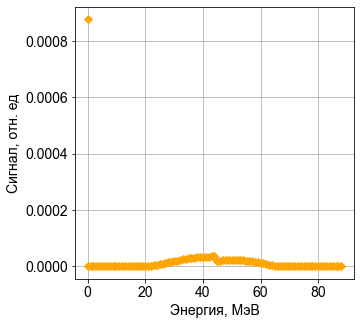

In [489]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(range(number_of_signals), SIGNALS[55][15], ls='-', marker='D', lw='0.7', ms=5, color='orange')
ax.plot(0, OPEN_SIGNALS[55][15], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Восстановление спектра

In [540]:
# создание матрицы задачи
Matrix = [get_coeff_simpson(response, en, EDGES)[0] for response in resp_rectangle]

In [541]:
sp = np.array([np.nan for i in range(signals_number)])
norm = np.array([np.nan for i in range(signals_number)])
decb = np.array([np.nan for i in range(signals_number)])
dev = np.array([np.nan for i in range(signals_number)])

new_en = get_coeff_simpson(resp_rectangle[0], en, EDGES)[1]

In [542]:
signals_simpson = SIGNALS[z_example][en_example]
brem_e = bremsstrahlungs[z_example][en_example]

In [543]:
import time
# восстановление спектра методом Голда на основании К-фильтров
start_time = time.time()
sp, norm, dev = Gold(Matrix, signals_simpson, en, brem_e, new_en, 1, 10000, w=True, d=False)[:3]
print(f'{round(time.time()-start_time, 6)} секунды')

4.105257 секунды


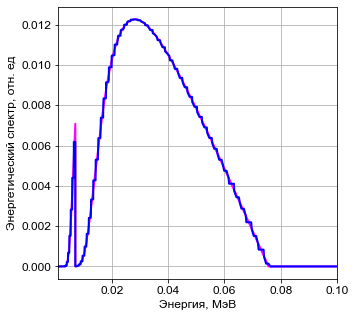

In [546]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(en, brem_e, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)